# Network Intrusion Detection System using AI

Ce notebook construit un système de détection d'intrusion réseau à double couche :
- **Détection par signature** (Random Forest, SVM, k-NN, MLP)
- **Détection d'anomalies** (Isolation Forest)

Le dataset utilisé est UNSW-NB15.

## 1. Import Libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import logging
import warnings
import time
import winsound
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, RandomizedSearchCV
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from utils import load_and_preprocess_data, plot_learning_curve,plot_training_metrics

# Supprimer les avertissements non nécessaires
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Création des dossiers pour les résultats
os.makedirs('figures/knn_improved', exist_ok=True)
os.makedirs('models', exist_ok=True)

# Configure logging for the classifier class
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Création des dossiers pour les résultats
os.makedirs('figures/mlp', exist_ok=True)

## 2. Data Loading and Exploration

In [12]:
# Load the dataset
df = pd.read_csv("../UNSW_NB15_training-set.csv")

# Display basic information
print("Dataset preview:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nClass distribution (label):")
print(df['label'].value_counts())
print("\nAttack categories (attack_cat):")
print(df['attack_cat'].value_counts())

Dataset preview:
   id       dur proto service state  spkts  dpkts  sbytes  dbytes  \
0   1  0.000011   udp       -   INT      2      0     496       0   
1   2  0.000008   udp       -   INT      2      0    1762       0   
2   3  0.000005   udp       -   INT      2      0    1068       0   
3   4  0.000006   udp       -   INT      2      0     900       0   
4   5  0.000010   udp       -   INT      2      0    2126       0   

          rate  ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  \
0   90909.0902  ...                 1               2             0   
1  125000.0003  ...                 1               2             0   
2  200000.0051  ...                 1               3             0   
3  166666.6608  ...                 1               3             0   
4  100000.0025  ...                 1               3             0   

   ct_ftp_cmd  ct_flw_http_mthd  ct_src_ltm  ct_srv_dst  is_sm_ips_ports  \
0           0                 0           1           2          

## 3. Data Visualization

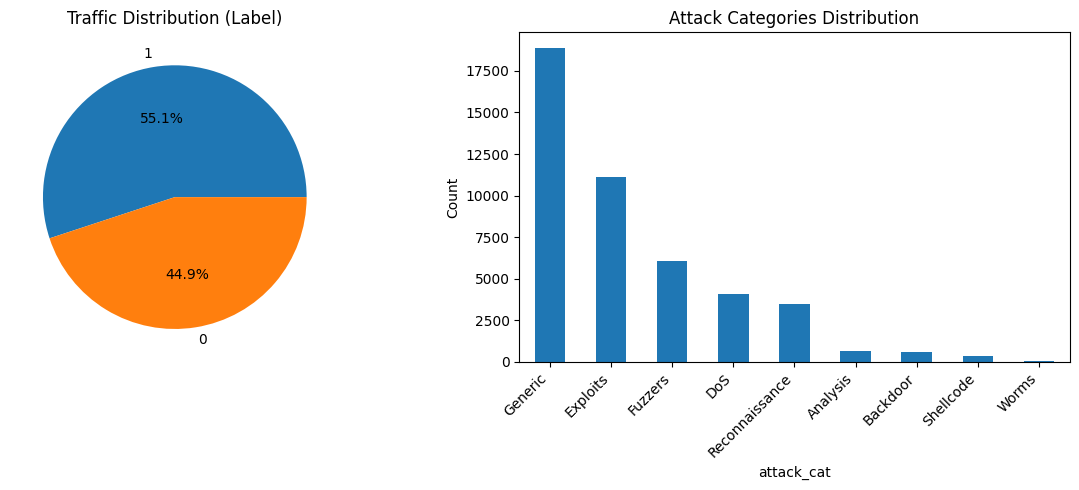

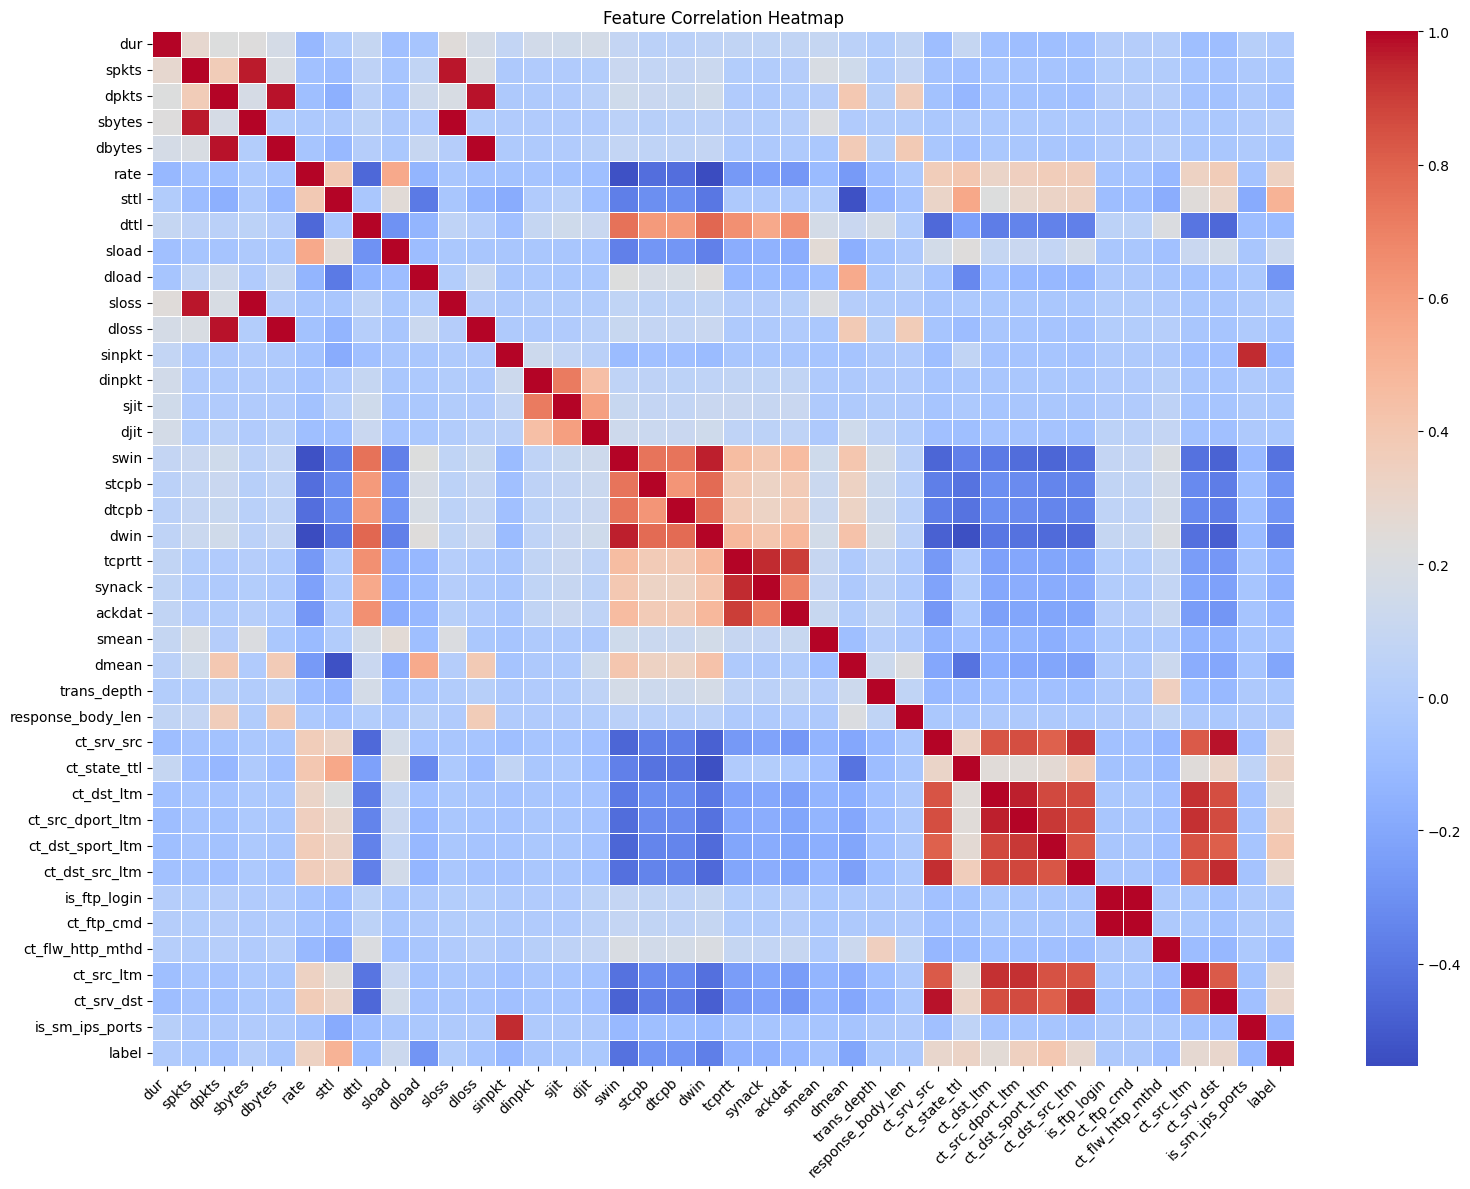

In [13]:
# Plot class distribution and attack categories
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax1)
ax1.set_title('Traffic Distribution (Label)')
ax1.set_ylabel('')

ax2 = plt.subplot(1, 2, 2)
attack_data = df[df['label'] == 1]['attack_cat'].value_counts()
attack_data.plot(kind='bar', ax=ax2)
ax2.set_title('Attack Categories Distribution')
ax2.set_ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlation heatmap of numeric features (excluding 'id')
plt.figure(figsize=(16, 12))
numeric_cols = df.select_dtypes(include=np.number).columns.drop('id', errors='ignore')
corr = df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Entraînement KNN 

### Explication de la Fonction `optimize_knn_hyperparameters`

La fonction `optimize_knn_hyperparameters` est conçue pour optimiser les hyperparamètres d'un modèle KNN (K-Nearest Neighbors) en utilisant une recherche aléatoire sur une grille de paramètres prédéfinie. Voici une explication détaillée de chaque étape :

1.  **Définition de la grille de paramètres :**
    *   Un dictionnaire `param_grid` est défini, contenant les hyperparamètres à optimiser et les valeurs possibles pour chacun d'eux.
        *   `n_neighbors`: Nombre de voisins à considérer (3, 5, 7, 9, 11, 15).
        *   `weights`: Pondération des voisins (uniforme ou basée sur la distance).
        *   `metric`: Métrique de distance à utiliser (euclidienne ou de Manhattan).
        *   `algorithm`: Algorithme utilisé pour calculer les plus proches voisins ('auto', 'ball_tree', 'kd_tree').

2.  **Création du modèle KNN :**
    *   Un modèle KNN est créé en utilisant la classe `KNeighborsClassifier` de scikit-learn.

3.  **Recherche par grille avec validation croisée :**
    *   La fonction utilise `RandomizedSearchCV` pour trouver les meilleurs hyperparamètres.
        *   `knn`: Le modèle KNN à optimiser.
        *   `param_grid`: La grille de paramètres à explorer.
        *   `cv`: Le nombre de plis pour la validation croisée (par défaut 3).
        *   `scoring`: La métrique à utiliser pour évaluer les performances (accuracy).
        *   `n_jobs`: Le nombre de cœurs de CPU à utiliser en parallèle (-1 pour utiliser tous les cœurs disponibles).
        *   `verbose`: Niveau de verbosité (1 pour afficher des informations pendant la recherche).

4.  **Entraînement du modèle :**
    *   La fonction entraîne le modèle en utilisant la méthode `fit` de `RandomizedSearchCV`.
    *   Le temps d'entraînement est mesuré pour évaluer l'efficacité de la recherche.

5.  **Évaluation sur l'ensemble de validation :**
    *   Une fois la recherche terminée, le modèle est évalué sur l'ensemble de validation en utilisant la méthode `predict` pour obtenir les prédictions, puis en calculant l'accuracy avec `accuracy_score`.

6.  **Affichage des résultats :**
    *   Les meilleurs hyperparamètres trouvés sont affichés, ainsi que le score de validation croisée et le score sur l'ensemble de validation.
    *   Les 3 meilleures combinaisons de paramètres sont également affichées, avec leurs scores moyens et écarts-types.

7.  **Gestion des erreurs :**
    *   Si une erreur se produit pendant l'optimisation, la fonction utilise des paramètres par défaut pour créer et entraîner un modèle KNN.

8.  **Retour des résultats :**
    *   La fonction retourne les meilleurs hyperparamètres trouvés et le score de validation.


In [14]:

def optimize_knn_hyperparameters(X_train, y_train, X_val, y_val, cv=3):
    """
    Optimise les hyperparamètres du modèle KNN
    Args:
        X_train: Caractéristiques d'entraînement
        y_train: Étiquettes d'entraînement
        X_val: Caractéristiques de validation
        y_val: Étiquettes de validation
        cv: Nombre de plis pour la validation croisée
    Returns:
        Meilleurs hyperparamètres et score
    """
    print(f"Optimisation des hyperparamètres KNN...")
    
    # Définir une grille de paramètres plus efficace
    param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    
    # Créer le modèle KNN
    knn = KNeighborsClassifier()
    
    # Utiliser GridSearchCV pour trouver les meilleurs hyperparamètres
    print(f"Lancement de la recherche par grille avec {cv} plis...")
    grid_search = RandomizedSearchCV(
        knn, param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1
    )
    
    try:
        # Entraîner le modèle avec gestion du temps
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        search_time = time.time() - start_time
        print(f"Recherche par grille terminée en {search_time:.2f} secondes")
        
        # Évaluer sur l'ensemble de validation
        val_score = accuracy_score(y_val, grid_search.predict(X_val))
        print(f"Meilleurs hyperparamètres: {grid_search.best_params_}")
        print(f"Score de validation croisée: {grid_search.best_score_:.4f}")
        print(f"Score sur l'ensemble de validation: {val_score:.4f}")
        
        # Afficher les 3 meilleures combinaisons de paramètres
        results = grid_search.cv_results_
        sorted_idx = np.argsort(results['mean_test_score'])[::-1]
        print("\nTop 3 des meilleures combinaisons de paramètres:")
        for i in range(min(3, len(sorted_idx))):
            idx = sorted_idx[i]
            print(f"Rang {i+1}: {results['params'][idx]}")
            print(f"  Score moyen: {results['mean_test_score'][idx]:.4f}")
            print(f"  Écart-type: {results['std_test_score'][idx]:.4f}")
        
        return grid_search.best_params_, val_score
    
    except Exception as e:
        print(f"Erreur lors de l'optimisation des hyperparamètres: {str(e)}")
        # Paramètres par défaut en cas d'erreur
        default_params = {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean', 'algorithm': 'auto'}
        print(f"Utilisation des paramètres par défaut: {default_params}")
        model = KNeighborsClassifier(**default_params)
        model.fit(X_train, y_train)
        val_score = accuracy_score(y_val, model.predict(X_val))
        return default_params, val_score


### Explication de la Fonction `train_knn_progressive`

La fonction `train_knn_progressive` est conçue pour entraîner un modèle KNN de manière progressive, en augmentant graduellement la taille de l'ensemble d'entraînement à chaque époque. Cette approche permet d'observer l'évolution des performances du modèle en fonction de la quantité de données utilisées pour l'entraînement. Voici une explication détaillée de chaque étape :

1.  **Initialisation :**
    *   La fonction prend en entrée les ensembles d'entraînement (X\_train, y\_train), de validation (X\_val, y\_val) et de test (X\_test, y\_test), les meilleurs hyperparamètres trouvés lors de l'optimisation (best\_params) et le nombre d'époques d'entraînement (n\_epochs).
    *   Elle initialise des listes pour stocker les métriques d'entraînement et de validation à chaque époque (accuracy, loss, precision, recall, f1-score).
    *   Elle initialise également des variables pour suivre le meilleur modèle (celui qui obtient la meilleure accuracy sur l'ensemble de validation).

2.  **Boucle d'entraînement :**
    *   La fonction effectue une boucle sur le nombre d'époques spécifié.
    *   À chaque époque, elle augmente progressivement la taille de l'ensemble d'entraînement en utilisant un ratio qui varie de train\_ratio\_start à train\_ratio\_end.
    *   Elle sélectionne un sous-ensemble aléatoire de l'ensemble d'entraînement en utilisant ce ratio.
    *   Elle crée un modèle KNN avec les meilleurs hyperparamètres trouvés et l'entraîne sur le sous-ensemble sélectionné.
    *   Elle évalue les performances du modèle sur les ensembles d'entraînement et de validation en calculant l'accuracy, la loss, la precision, le recall et le f1-score.
    *   Elle met à jour le meilleur modèle si les performances sur l'ensemble de validation sont meilleures que celles du meilleur modèle précédent.

3.  **Évaluation finale :**
    *   Une fois la boucle d'entraînement terminée, la fonction évalue les performances du meilleur modèle sur l'ensemble de test en calculant l'accuracy, la precision, le recall et le f1-score.
    *   Elle calcule également la matrice de confusion pour analyser les erreurs de classification du modèle.

4.  **Traçage des courbes d'apprentissage :**
    *   La fonction trace les courbes d'apprentissage pour visualiser l'évolution des métriques d'entraînement et de validation au fil des époques.
    *   Elle trace également la matrice de confusion pour visualiser les performances du modèle sur l'ensemble de test.

5.  **Retour des résultats :**
    *   La fonction retourne un dictionnaire contenant les informations d'apprentissage (métriques d'entraînement et de validation, courbes d'apprentissage) et le meilleur modèle.

In [23]:
def train_knn_simple(X_train, y_train, X_val, y_val, X_test, y_test, best_params):
    """
    Entraînement KNN simple et correct
    """
    print("Entraînement KNN (stockage des données)...")
    
    # Un seul entraînement suffit
    model = KNeighborsClassifier(**best_params)
    model.fit(X_train, y_train)  # Stocke toutes les données une fois
    
    # Évaluation directe
    val_pred = model.predict(X_val)
    test_pred = model.predict(X_test)
    
    # Métriques
    val_accuracy = accuracy_score(y_val, val_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    test_precision = precision_score(y_test, test_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, test_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, test_pred, average='weighted', zero_division=0)
    return {
        'model': model,
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'confusion_matrix': confusion_matrix(y_test, test_pred)
    }

In [26]:



def main(data_path="UNSW_NB15_training-set.csv", test_size=0.2, val_size=0.15, n_epochs=50, random_state=42):
    """
    Fonction principale qui exécute tout le pipeline
    """
    start_time = time.time()
    
    try:
        # Charger et prétraiter les données
        X_train, X_val, X_test, y_train, y_val, y_test, scaler, label_encoders = load_and_preprocess_data(
            filepath=data_path, test_size=test_size, val_size=val_size, random_state=random_state
        )
        
        # Sauvegarder le scaler et les encodeurs
        try:
            joblib.dump(scaler, "models/scaler.pkl")
            joblib.dump(label_encoders, "models/label_encoders.pkl")
            print("✅ Scaler et encodeurs sauvegardés dans le dossier 'models/'")
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du scaler et des encodeurs: {str(e)}")
        
        # Optimiser les hyperparamètres
        # best_params, val_score = optimize_knn_hyperparameters(X_train, y_train, X_val, y_val)
        best_params = {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan', 'algorithm': 'auto'}
        # Tracer la courbe d'apprentissage pour évaluer l'impact de la taille de l'ensemble d'entraînement
        model = KNeighborsClassifier(**best_params)
        # plot_learning_curve(model, X_train, y_train)
        
        # Entraînement progressif
        results = train_knn_simple(X_train, y_train, X_val, y_val, X_test, y_test, best_params)
        
        # Sauvegarder le meilleur modèle
        try:
            joblib.dump(results['model'], "models/KNN_best.pkl")
            print("✅ Meilleur modèle KNN sauvegardé dans models/KNN_best.pkl")
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du modèle: {str(e)}")
        
        # Affichage du temps total d'exécution
        elapsed_time = time.time() - start_time
        print(f"\nTemps total d'exécution: {elapsed_time:.2f} secondes ({elapsed_time/60:.2f} minutes)")
        
        # Résumé des performances
        print(f"\n📊 Résumé des performances:")
        print(f"  - Accuracy finale sur le test: {results['test_accuracy']:.4f}")
        print(f"  - Precision finale sur le test: {results['test_precision']:.4f}")
        print(f"  - Recall final sur le test: {results['test_recall']:.4f}")
        print(f"  - F1-Score final sur le test: {results['test_f1']:.4f}")
        print(f"  - Meilleurs hyperparamètres: {best_params}")
        
        # Évaluation finale du modèle
        print("\n🔍 Analyse de la matrice de confusion:")
        conf_matrix = results['confusion_matrix']
        tn, fp, fn, tp = conf_matrix.ravel()
        print(f"  - Vrais Négatifs (Normal correctement identifié): {tn}")
        print(f"  - Faux Positifs (Normal classé comme Attaque): {fp}")
        print(f"  - Faux Négatifs (Attaque classée comme Normale): {fn}")
        print(f"  - Vrais Positifs (Attaque correctement identifiée): {tp}")
        
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        print(f"  - Spécificité (Taux de vrais négatifs): {specificity:.4f}")
        
        winsound.Beep(1000, 500)  # Bip de 1 seconde à 1000 Hz
        return results
    
    except Exception as e:
        print(f"\n❌ Erreur lors de l'exécution du pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
        return None


In [27]:

if __name__ == "__main__":
    # Point d'entrée du script
    print("=" * 80)
    print("Pipeline d'analyse et d'entraînement KNN pour la détection d'intrusion réseau")
    print("=" * 80)
    
    # Vérifier si le fichier de données existe
    data_path = "../UNSW_NB15_training-set.csv"
    if not os.path.exists(data_path):
        print(f"⚠️ Le fichier {data_path} n'existe pas. Veuillez spécifier le chemin correct.")
        data_path = input("Chemin du fichier de données: ")
    
    # Exécuter le pipeline principal
    main(data_path=data_path, n_epochs=25)

Pipeline d'analyse et d'entraînement KNN pour la détection d'intrusion réseau
Chargement et prétraitement des données depuis ../UNSW_NB15_training-set.csv...
Données chargées: 82332 lignes et 45 colonnes
Distribution des classes:
  - Classe 1: 45332 échantillons (55.06%)
  - Classe 0: 37000 échantillons (44.94%)
Encodage des 3 colonnes catégorielles:
  - proto: 131 valeurs uniques
  - service: 13 valeurs uniques
  - state: 7 valeurs uniques
Dimensions des ensembles de données:
  Train: X=(53515, 42), y=(53515,)
  Validation: X=(12350, 42), y=(12350,)
  Test: X=(16467, 42), y=(16467,)
Distribution des classes dans les ensembles:
  Train: [24050 29465]
  Validation: [5550 6800]
  Test: [7400 9067]
✅ Scaler et encodeurs sauvegardés dans le dossier 'models/'
Entraînement KNN (stockage des données)...
✅ Meilleur modèle KNN sauvegardé dans models/KNN_best.pkl

Temps total d'exécution: 13.26 secondes (0.22 minutes)

📊 Résumé des performances:
  - Accuracy finale sur le test: 0.9452
  - Precis